In [99]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import tensorflow.contrib.layers as layers
import tensorflow.contrib.slim as slim
from random import shuffle

In [100]:
total_azimuth_angles = 36
train_split = 0.8
image_H, image_W, image_D = 64,64,3
pose_w, pose_h, pose_d = 4,4,36

In [101]:
dataset = np.load('../datasets/chair_copy.npy')


94666752


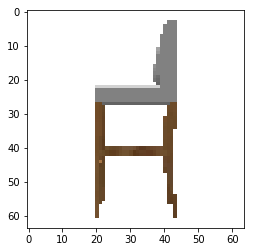

In [102]:
print(dataset.nbytes)
plt.imshow(dataset[711]/255)
plt.show()

In [103]:
 
total_models = dataset.shape[0] // total_azimuth_angles


train_models_len = int(total_models * train_split)
test_models_len = total_models - train_models_len

print(total_models,train_models_len,test_models_len)

214 171 43


In [104]:
dataset_train = dataset[:train_models_len*total_azimuth_angles]
dataset_test = dataset[train_models_len*total_azimuth_angles:]

print(dataset_test.shape)
print(dataset_train.shape)

(1548, 64, 64, 3)
(6156, 64, 64, 3)


In [105]:
del dataset
dataset_train.nbytes

75644928

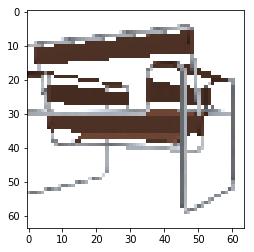

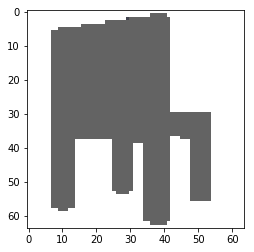

In [106]:
plt.imshow(dataset_train[1023]/255)
plt.show()
plt.imshow(dataset_test[1023]/255)
plt.show()

In [107]:
train_pairs = []
start_pose = [0]
for i in range(train_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                train_pairs.append((i,j,k))
                
test_pairs = []
start_pose = [0]
for i in range(test_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                test_pairs.append((i,j,k))


In [108]:
print(train_pairs[35])
print(test_pairs[35])
shuffle(train_pairs)
shuffle(test_pairs)
print(train_pairs[35])
print(test_pairs[35])

(1, 0, 1)
(1, 0, 1)
(45, 0, 17)
(34, 0, 13)


(169, 0, 16)
(39, 0, 21)
5985


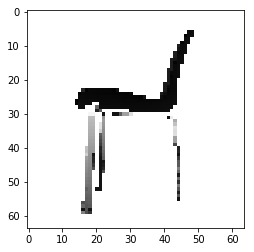

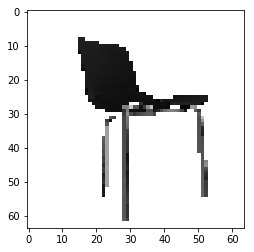

In [109]:
print(train_pairs[0])
print(test_pairs[0])

print(len(train_pairs))

i = dataset_train[(10*36) + 27]
j = dataset_train[(10*36) + 5]
plt.imshow(i/255)
plt.show()
plt.imshow(j/255)
plt.show()

In [110]:
def normalize(data):
    data = data * 2.0
    data = data / 255.0
    data = data - 1.0
    return data

def denormalize(data):
    data = data + 1.0
    data = data * 255.0
    data = data / 2.0
    return data

In [111]:
c = 0
for p in train_pairs:
    if p[0] == 12 and p[1] == 0:
        c += 1
print(c)

35


In [112]:
#pairs (index_no, input, output)
def get_batch_data(pairs, train=True):
    l = train_models_len if train else test_models_len
    d = dataset_train if train else dataset_test
    i, ip, op = 0, 1, 2
    batch, batch_labels, pose = [], [], []
    for p in pairs:
        ip_index = (p[i] * total_azimuth_angles) + p[1]
        batch.append(d[ip_index])
        
        op_index = (p[i] * total_azimuth_angles) + p[2]
        batch_labels.append(d[op_index])
        
        cur_pose =  np.zeros(36, dtype='uint8')
        cur_pose[(p[2] - p[1]) % total_azimuth_angles] = 1
        pose.append(np.broadcast_to(cur_pose,(pose_w, pose_h, pose_d)))
        
    batch = np.array(batch, dtype=np.float64)
    batch_labels = np.array(batch_labels, dtype=np.float64)
    pose = np.array(pose, dtype=np.float64)
    
    #normalize
    batch = normalize(batch)
    batch_labels =  normalize(batch_labels)
    
    return batch,batch_labels,pose

batch, batch_labels, pose_labels = get_batch_data(test_pairs[35*36:36*36], False)

(36, 64, 64, 3) (36, 64, 64, 3) (36, 4, 4, 36)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
<class 'numpy.float64'>
1.0 -0.945098039216


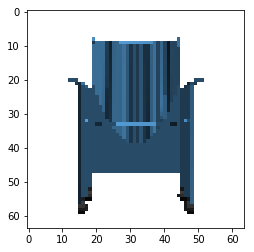

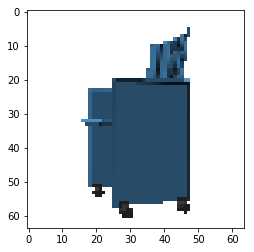

In [113]:
print(batch.shape, batch_labels.shape, pose_labels.shape)

t = 13
print(pose_labels[t][0][0])

print(type(batch_labels[t][0][0][0]))

print(np.max((batch[t])), np.min((batch[t])))

plt.imshow(denormalize(batch[t]) / 255)
plt.show()
plt.imshow(denormalize(batch_labels[t]) / 255)
plt.show()


In [114]:
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)


def conv2d(input, output, kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2d", act=lrelu):
    #act = tf.nn.leaky_relu
    with tf.variable_scope(scope_name):
        return layers.conv2d(inputs=input, num_outputs=output, kernel_size=[kernel_h, kernel_w], stride=k_stride, activation_fn=act,
         #biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02))
         biases_initializer=tf.zeros_initializer(), weights_initializer=tf.contrib.layers.xavier_initializer())
    
def deconv2d(input, kernel_size, stride, num_filter, scope_name='deconv2d', act=lrelu):
    with tf.variable_scope(scope_name): 
        stride_shape = [stride, stride]
        kernel_shape = [kernel_size, kernel_size]
        return layers.conv2d_transpose(inputs=input, num_outputs=num_filter, stride=stride_shape, kernel_size= kernel_shape,
            #padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02),
            padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.contrib.layers.xavier_initializer(),
            activation_fn=act
        )

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')


def batch_norm(inputs_, is_training):
    out = tf.contrib.layers.batch_norm(inputs_, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def l1_loss(inputs_, targets_):
    loss = tf.reduce_mean(abs(inputs_ - targets_))
    return loss

def ce_loss(labels, logits):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
    return tf.reduce_mean(loss)

def local_moment_loss(pred, gt):
    with tf.name_scope('local_moment_loss'):

        ksz, kst = 4, 2
        local_patch = tf.ones((ksz, ksz, 1, 1))
        c = pred.get_shape()[-1]

        # Normalize by kernel size
        pr_mean = tf.concat([tf.nn.conv2d(x, local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(pred, c, axis=3)], axis=3)
        pr_var = tf.concat([tf.nn.conv2d(tf.square(x), local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(pred, c, axis=3)], axis=3)
        pr_var = (pr_var - tf.square(pr_mean)/(ksz**2)) / (ksz ** 2)
        pr_mean = pr_mean / (ksz ** 2)

        gt_mean = tf.concat([tf.nn.conv2d(x, local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(gt, c, axis=3)], axis=3)
        gt_var = tf.concat([tf.nn.conv2d(tf.square(x), local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(gt, c, axis=3)], axis=3)
        gt_var = (gt_var - tf.square(gt_mean)/(ksz**2)) / (ksz ** 2)
        gt_mean = gt_mean / (ksz ** 2)

        # scaling by local patch size
        local_mean_loss = tf.reduce_mean(tf.abs(pr_mean - gt_mean))
        local_var_loss = tf.reduce_mean(tf.abs(pr_var - gt_var))
    return local_mean_loss + local_var_loss
    

In [115]:
tf.reset_default_graph()

In [116]:
batch_size = 36
# tf Graph input (only pictures)
inputs_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="target")
pose_ = tf.placeholder(tf.float32, (batch_size, pose_w, pose_h, pose_d), name="pose")

disc_inputs = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")

real_label = tf.placeholder(tf.float32, [batch_size, 1])
fake_label = tf.placeholder(tf.float32, [batch_size, 1])

In [117]:
ae_reuse= False
disc_reuse = False

#https://github.com/skaae/vaeblog

def auto_encoder(inputs_, pose_):
    global ae_reuse
    with tf.variable_scope('encoder', reuse=ae_reuse):
        ae_reuse = True
        _ = conv2d(inputs_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv1",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=48 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=64 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv3",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=92 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv4",act=lrelu)
        _ = tf.concat([pose_, _], 3)
       

        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=64, scope_name='deconv1',act=lrelu)
        _ = batch_norm(_, True)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=32, scope_name='deconv2',act=lrelu)
        _ = batch_norm(_, True)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=16, scope_name='deconv3',act=lrelu) # act
        gact = _
        _ = batch_norm(_, True)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=3, scope_name='deconv4',act=None)
        print("O1", _.get_shape())
        _ = tf.nn.tanh(_)
    return _ , gact

'''
def generator(inputs_)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=32, scope_name='deconv2',act=lrelu)
        _ = batch_norm(_, True)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=16, scope_name='deconv3',act=lrelu)
        _ = batch_norm(_, True)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=3, scope_name='deconv4',act=None)
        print("O1", _.get_shape())
        _ = tf.nn.tanh(_)
    return _ 
'''

# discriminator should give a fc layer
# No batch norm layer
def discriminator(inputs_):
    global disc_reuse 
    with tf.variable_scope('dis', reuse=disc_reuse):
        disc_reuse = True
        
        _ = conv2d(inputs_, output=32 ,kernel_h=5, kernel_w=5, k_stride=2, scope_name="dis_conv1", act=lrelu)
        print(_.get_shape())
        _ = conv2d(_, output=64 ,kernel_h=5, kernel_w=5, k_stride=2, scope_name="dis_conv2", act=lrelu) # act
        dact = _
        _ = tf.nn.dropout(_, keep_prob = 0.5, name='dis_drop_1')
        _ = conv2d(_, output=128 ,kernel_h=5, kernel_w=5, k_stride=2, scope_name="dis_conv3", act=lrelu)
        _ = tf.nn.dropout(_, keep_prob = 0.5, name='dis_drop_2')
        _ = tf.reshape(_, [-1, 8 * 8 * 128])        
        _ = fc(_, 1, 'dis_fc1')
        o1 = tf.nn.sigmoid(_)
        o2 = _
        o3 = dact
        return o1, o2, o3


In [118]:
global_step = tf.Variable(0,trainable=False)
lr = 5e-4

In [119]:
alpha = 0.000001 #0.2
beta = 1.0 #1.0


'''
generated_images = auto_encoder(inputs_, pose_)
noise = np.random.normal(0, 0.2, inputs_.get_shape()).astype(np.float32)
generated_noise = auto_encoder(noise, pose_)

dreal, dreal_logits = discriminator(disc_inputs)
dfake, dfake_logits = discriminator(generated_images)
dnoise, dnoise_logits = discriminator(generated_noise)


dreal_labels = tf.zeros_like(dreal, dtype=tf.float32)
dfake_labels = 0.98 * tf.ones_like(dfake, dtype=tf.float32)

dreal_loss = ce_loss(dreal_labels, dreal_logits) #+ 0.2 * ce_loss(dfake_labels, dnoise_logits)
dfake_loss = ce_loss(dfake_labels, dfake_logits)# + 
dis_loss_op = dreal_loss + dfake_loss 


#gan_loss = alpha * ce_loss(tf.zeros_like(dfake), dfake_logits)
#gan_loss = alpha * ce_loss(tf.ones_like(dfake), dfake_logits)


supervised_loss = beta * l1_loss(generated_images, targets_)
#supervised_loss = beta * local_moment_loss(generated_images, targets_)
gen_loss_op = gan_loss + supervised_loss
'''


generated_images, g_act_real = auto_encoder(inputs_, pose_)
noise = np.random.normal(0, 0.2, inputs_.get_shape()).astype(np.float32)
generated_noise, g_act_noise = auto_encoder(noise, pose_)

dreal, dreal_logits, dact_real = discriminator(disc_inputs)
dfake, dfake_logits, dact_fake = discriminator(generated_images)
dnoise, dnoise_logits, dact_noise = discriminator(generated_noise)


dreal_labels = tf.zeros_like(dreal, dtype=tf.float32)
dfake_labels = 0.98 * tf.ones_like(dfake, dtype=tf.float32)

dreal_loss = ce_loss(dreal_labels, dreal_logits) #+ 0.2 * ce_loss(dfake_labels, dnoise_logits)
dfake_loss = ce_loss(dfake_labels, dfake_logits)# + 
dis_loss_op = dreal_loss + dfake_loss 


g_act_real = tf.contrib.layers.flatten(g_act_real)
dact_real = tf.contrib.layers.flatten(dact_real)
g_act_noise = tf.contrib.layers.flatten(g_act_noise)
dact_noise = tf.contrib.layers.flatten(dact_noise)
#gan_loss = alpha * ce_loss(tf.zeros_like(dfake), dfake_logits)
#gan_loss = alpha * ce_loss(tf.ones_like(dfake), dfake_logits)
gan_loss = tf.sqrt(tf.reduce_sum(tf.pow((g_act_real - dact_real), 2))) +  tf.sqrt(tf.reduce_sum(tf.pow(tf.nn.l2_loss(g_act_noise - dact_noise), 2)))
#gan_loss = alpha * gan_loss
supervised_loss = beta * l1_loss(generated_images, targets_)
#supervised_loss = beta * local_moment_loss(generated_images, targets_)
gen_loss_op = alpha * gan_loss + supervised_loss

# Build Loss
#gen_loss_op = -tf.reduce_mean(tf.log(dis_fake_samples_op))
#dis_loss_op = -tf.reduce_mean(tf.log(dis_real_samples_op) + tf.log(1. - dis_fake_samples_op))

# Build Optimizers
#optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
#optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)




O1 (36, 64, 64, 3)
O1 (36, 64, 64, 3)
(36, 32, 32, 32)
(36, 32, 32, 32)
(36, 32, 32, 32)


In [120]:
disriminator_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
generator_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder')
#print (generator_vars)
#dis_optimizer = tf.train.RMSPropOptimizer(lr)
#dis_train_op = dis_optimizer.minimize(dis_loss_op, var_list=disriminator_vars)
#gen_optimizer = tf.train.RMSPropOptimizer(lr)
#gen_train_op = gen_optimizer.minimize(gen_loss_op, var_list=generator_vars)


#dis_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
#dis_train_op = dis_optimizer.minimize(dis_loss_op, var_list=disriminator_vars)
#gen_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
#gen_train_op = gen_optimizer.minimize(gen_loss_op, var_list=generator_vars)
dlr = 1e-6#1e-4
glr = 1e-3#5e-4

#dis_optimizer = tf.train.AdamOptimizer(dlr)
#dis_train_op = dis_optimizer.minimize(dis_loss_op, var_list=disriminator_vars)

#gen_optimizer = tf.train.AdamOptimizer(glr)
#gen_train_op = gen_optimizer.minimize(gen_loss_op, var_list=generator_vars)

'''
dis_optimizer = tf.train.AdamOptimizer(learning_rate=dlr)
gvs = dis_optimizer.compute_gradients(dis_loss_op, var_list=generator_vars)
gcapped_gvs = [(tf.clip_by_value(grad, -10.0, 10.0), var) for grad, var in gvs]
dis_train_op = dis_optimizer.apply_gradients(gcapped_gvs)


gen_optimizer = tf.train.AdamOptimizer(learning_rate=glr)
gvs = gen_optimizer.compute_gradients(dis_loss_op, var_list=disriminator_vars)
dcapped_gvs = [(tf.clip_by_value(grad, -10.0, 10.0), var) for grad, var in gvs]
dis_train_op = dis_optimizer.apply_gradients(dcapped_gvs)
'''


dis_optimizer = tf.train.AdamOptimizer(learning_rate=dlr)
dgradients, dvariables = zip(*dis_optimizer.compute_gradients(dis_loss_op, var_list=disriminator_vars))
dgradients, _ = tf.clip_by_global_norm(dgradients, 5.0)
dis_train_op = dis_optimizer.apply_gradients(zip(dgradients, dvariables))


gen_optimizer = tf.train.AdamOptimizer(learning_rate=glr)
ggradients, gvariables = zip(*gen_optimizer.compute_gradients(gen_loss_op, var_list=generator_vars))
ggradients, _ = tf.clip_by_global_norm(ggradients, 5.0)
gen_train_op = gen_optimizer.apply_gradients(zip(ggradients, gvariables))







In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 10
total_images = len(train_pairs)
step = 0

r = total_images // batch_size
l = len(dataset_train) // batch_size

dis_losses = []
gen_losses = []




'''
local margin = 0.3
     sgdState_D.optimize = true
     sgdState_G.optimize = true
if err_F < margin or err_R < margin then
     sgdState_D.optimize = false
end
if err_F > (1.0-margin) or err_R > (1.0-margin) then
     sgdState_G.optimize = false
end
if sgdState_G.optimize == false and sgdState_D.optimize == false then
     sgdState_G.optimize = true
     sgdState_D.optimize = true
end
'''


real_m, fake_m = 0.2, 0.2
margin = 0.2 #(0.1*0.3 + 0.1 = 0.13)
doptim, goptim = True, True
_fake, _real = 0.5, 0.5
gen_loss = 1.0
dis_los = 0.5

gen_gan_t = 0.06
gan = 1.0

g_threshold = 0.13



for epoch in range(epochs):
    for ii in range(r):
        step += 1
        #zeros = np.zeros([batch_size, 1])* ((np.random.random_sample() *0.4) - 0.2)
        zeros = np.zeros([batch_size, 1])
        ones = np.ones([batch_size, 1]) * ((np.random.random_sample() *0.5) + 0.7)
        
        d_pairs = train_pairs[ii*batch_size : (ii+1)*batch_size]
        batch, batch_labels, pose_labels = get_batch_data(d_pairs)

        
        k = np.random.randint(1,l-1)
        d_inputs = dataset_train[k*batch_size : (k+1)*batch_size]
        
        feed_dict = {inputs_: batch, targets_: batch_labels, pose_: pose_labels,
                    fake_label: zeros, real_label: ones, disc_inputs: d_inputs}
        fetch_val = [gen_loss_op, dis_loss_op, dreal_loss, dfake_loss, gan_loss, supervised_loss]
            
        #if _fake > (1.0 - fake_m) or _real > (1.0 - real_m):
        #    goptim = False
        
        #if gen_loss < 0.34:
        #    goptim = False
            
        #if gen_loss > margin
        
        if _real < real_m or _fake < fake_m or dis_los < margin:
            doptim = False
            
        #if gen_loss < (g_threshold):
        #    goptim = False
        
        #if gan < gen_gan_t:
        #    goptim = False
            
        #if goptim == False and doptim == False:
        #    goptim, doptim = True, True
        
        if step % 5 or _real < real_m or _fake < fake_m or dis_los < margin: # biased towards generator
            fetch_val.append(gen_train_op)
        else:
            fetch_val.append(dis_train_op) 
        
        
        gen_loss, dis_loss, _real, _fake, gan, superl,_ = sess.run(fetch_val, feed_dict = feed_dict)

        dis_losses.append(dis_loss)
        gen_losses.append(gen_loss)
        
        #print(goptim, doptim)

        if step % 10 == 0:
            print('Step {0}: dloss = {1:.4f}, gloss = {2:.4f}, real_loss = {3:.4f}, fake_loss = {4:.4f}, gan_loss = {5:.4f} l1_loss = {6:.4f}'.format(step, dis_loss, gen_loss, _real, _fake, gan, superl))
            
    print('Epoch {0}: dis loss = {1:.4f}, gen loss = {2:.4f}, real_label_loss = {3:.4f}, fake_label_loss = {4:.4f}'.format(epoch, dis_loss, gen_loss, _real, _fake))
    plt.plot(dis_losses)
    plt.title('discriminator loss')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()

    plt.plot(gen_losses)
    plt.title('generator loss')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()

In [91]:
dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder')
saver = tf.train.Saver(dis_var_list + gen_var_list)
saver.save(sess, 'model/dcgan_pose_car_op_one_pose')

'model/dcgan_pose_car_op_one_pose'

In [92]:
d_pairs = test_pairs[5 * batch_size : 6 * batch_size]
test_batch, test_labels, test_pose = get_batch_data(d_pairs, False)

In [93]:
feed_dict = { inputs_: test_batch, pose_: test_pose}
op = sess.run([generated_images], feed_dict = feed_dict)

In [94]:
j = 20
op = denormalize(op[0])



In [95]:
#op = op.astype(np.uint8)
print(np.min(op), np.max(op))
#print(np.where(op < -0.00001 ))

#print(op[0][0][59])

-3.03984e-05 255.0


In [96]:
op = np.where(op < 0.0,0.0, op)

In [97]:
print(np.min(op), np.max(op))

0.0 255.0


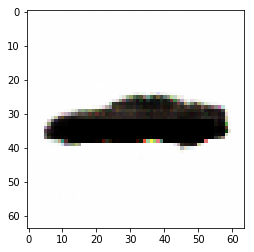

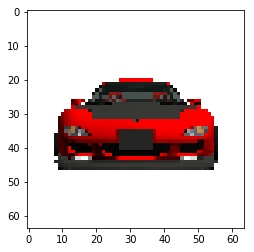

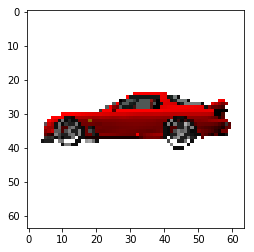

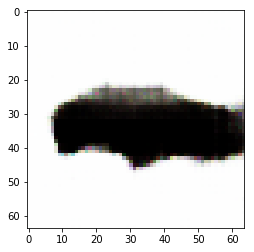

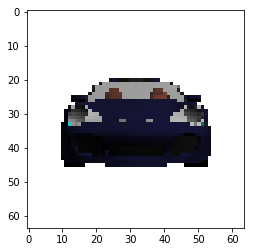

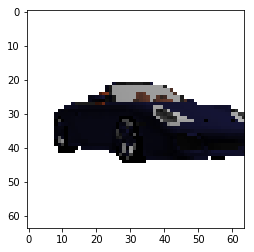

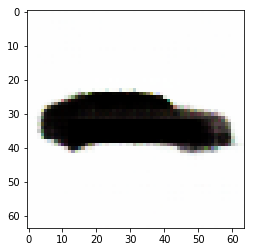

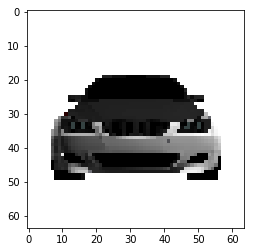

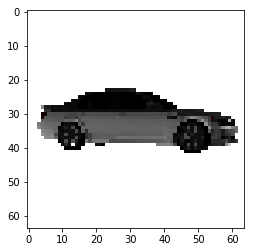

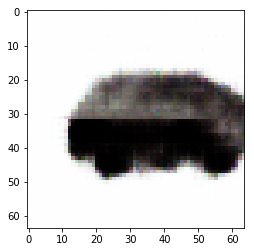

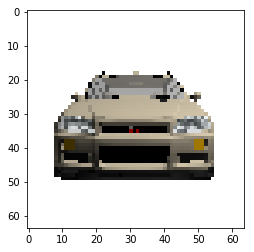

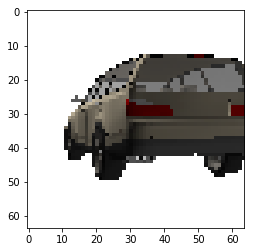

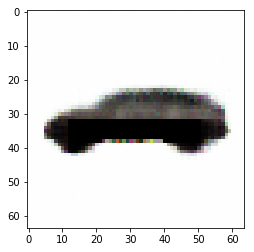

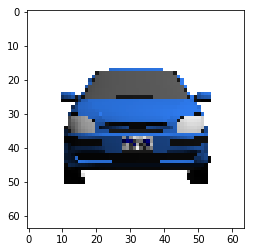

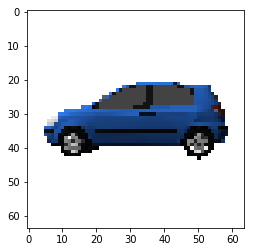

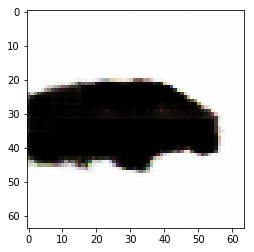

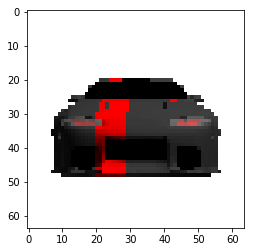

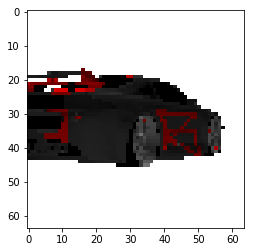

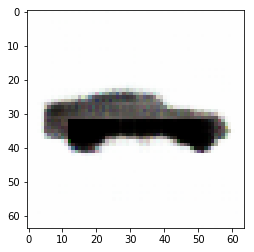

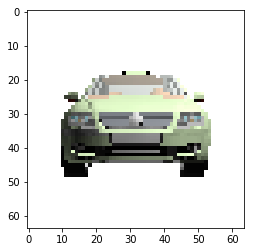

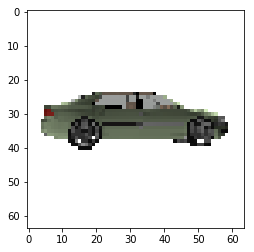

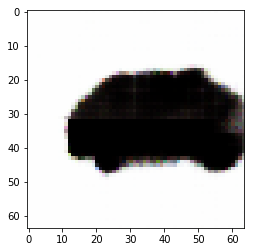

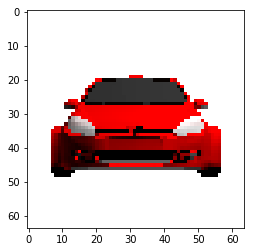

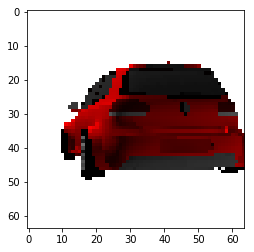

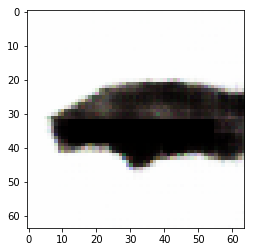

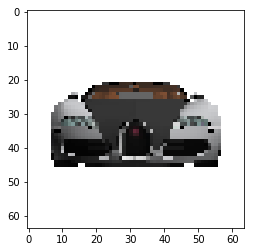

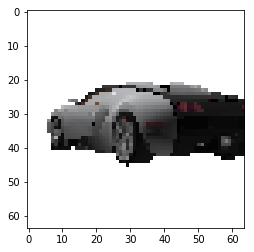

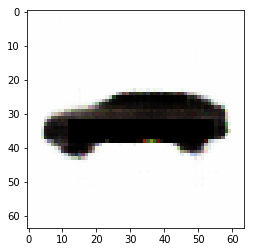

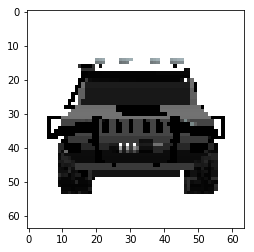

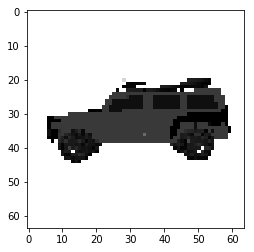

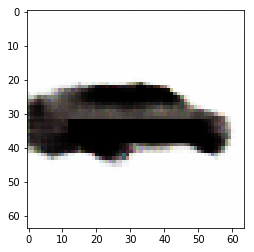

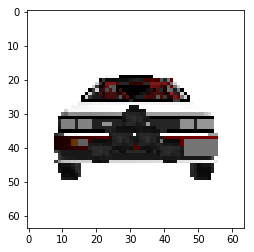

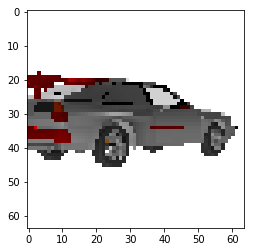

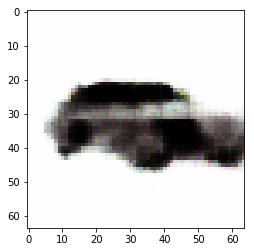

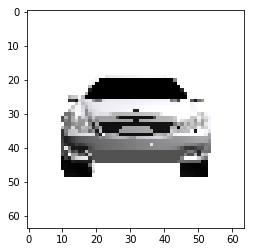

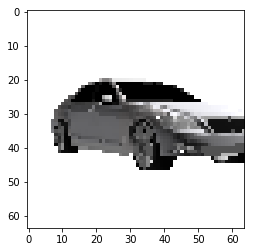

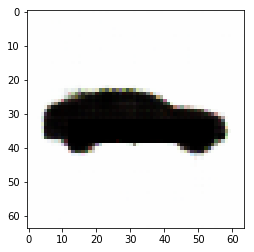

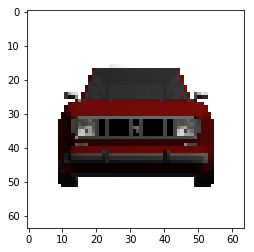

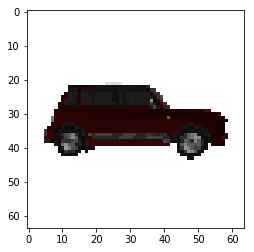

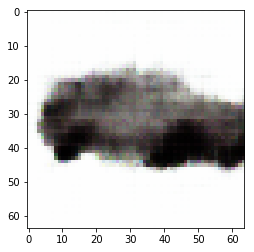

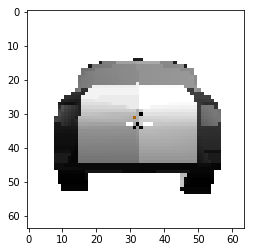

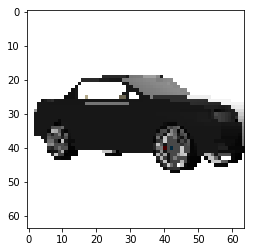

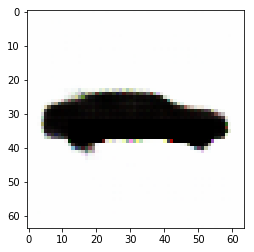

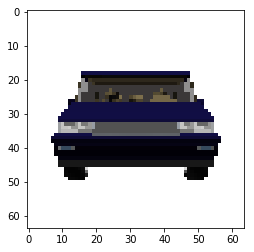

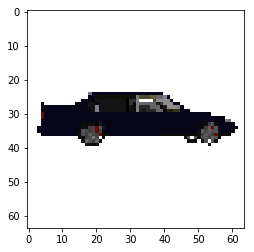

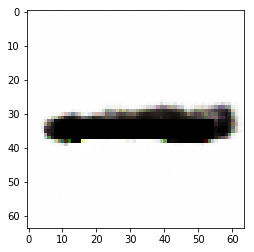

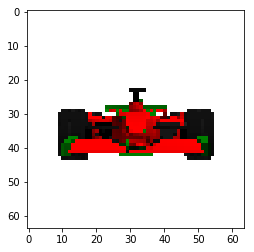

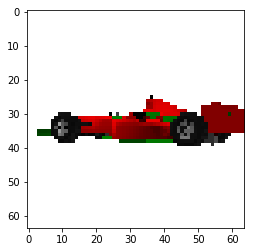

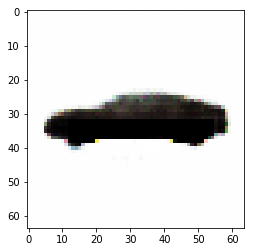

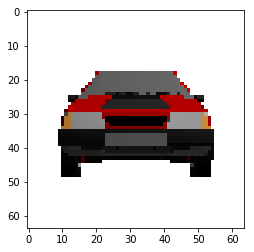

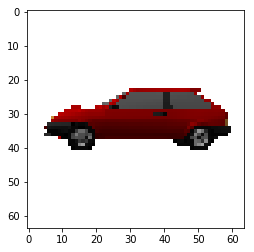

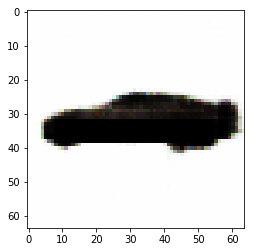

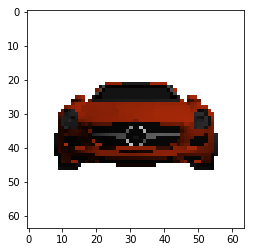

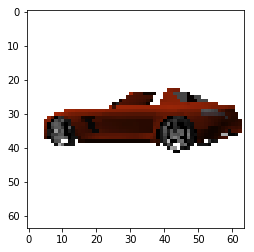

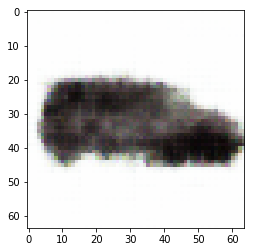

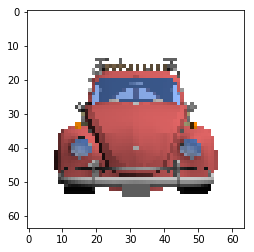

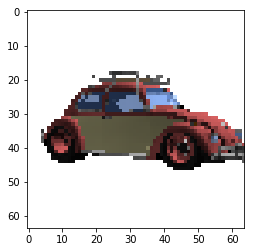

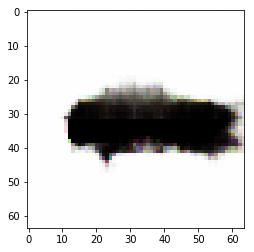

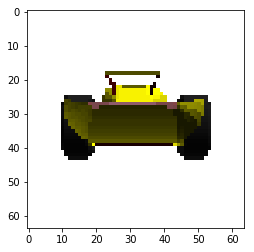

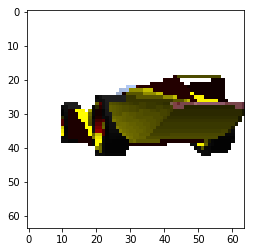

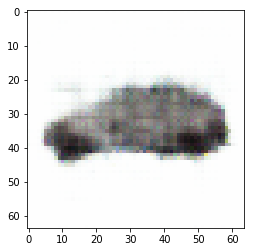

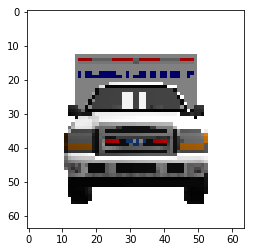

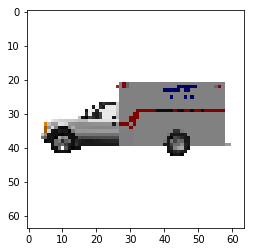

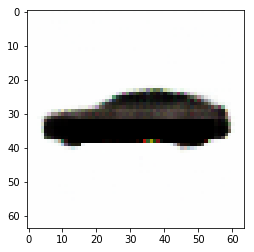

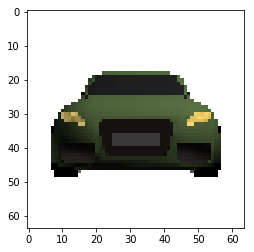

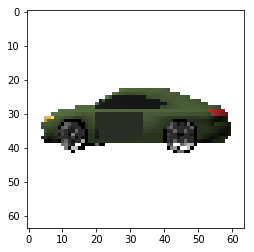

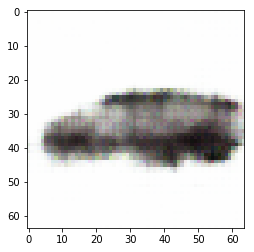

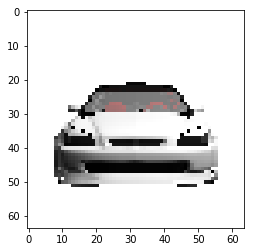

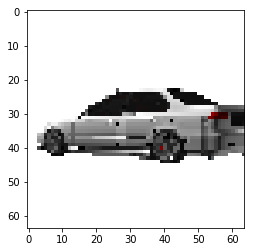

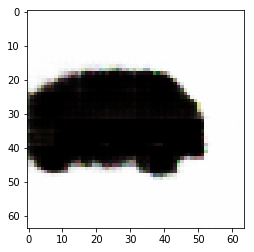

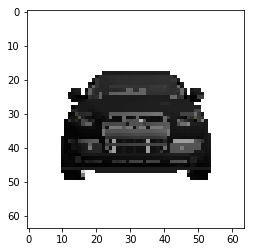

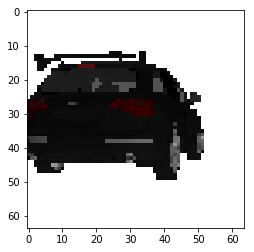

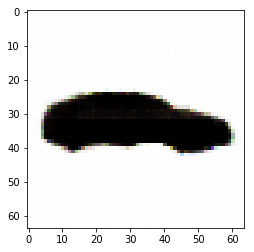

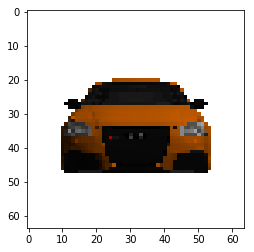

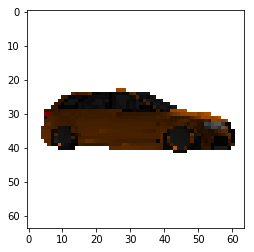

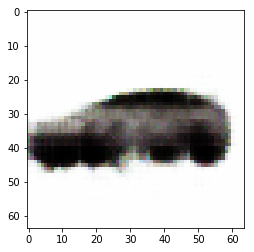

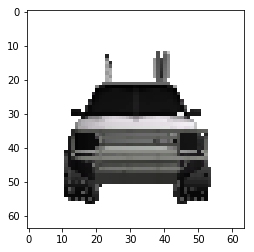

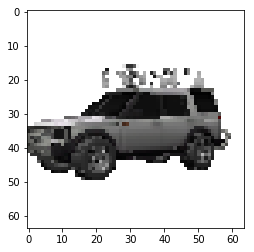

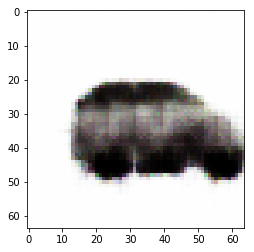

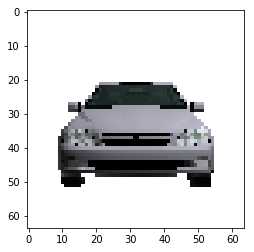

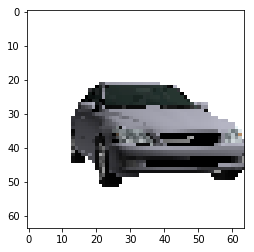

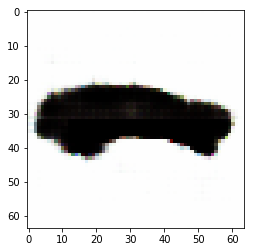

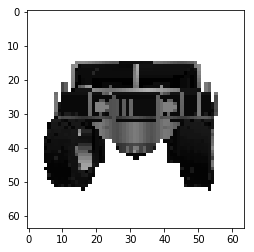

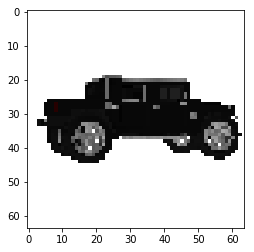

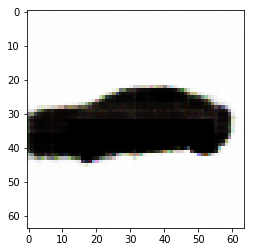

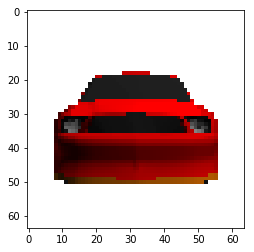

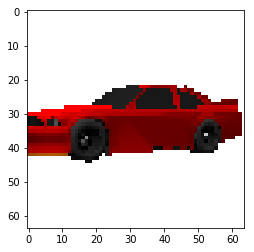

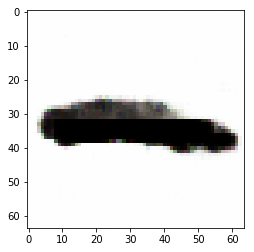

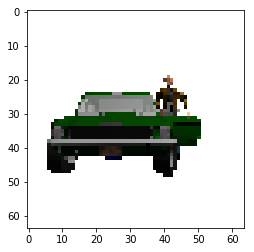

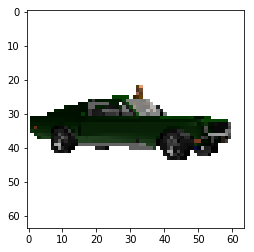

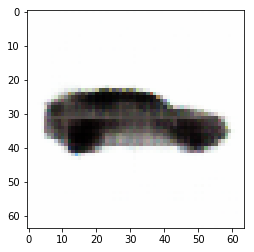

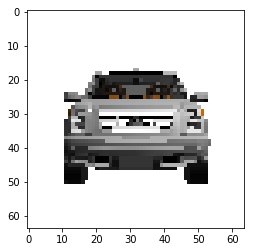

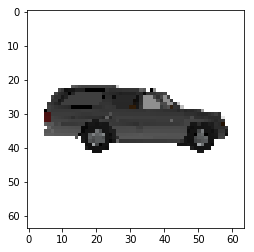

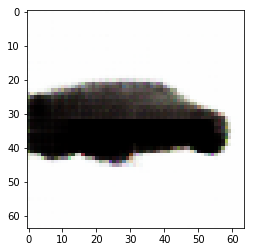

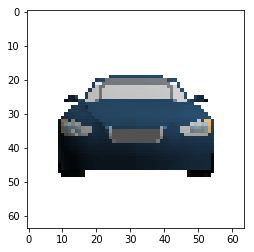

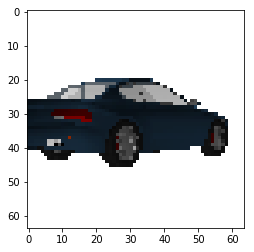

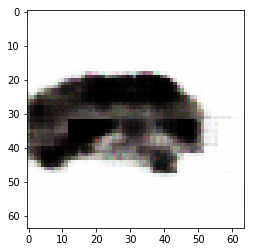

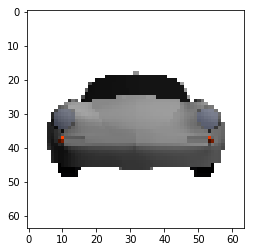

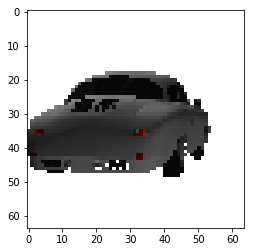

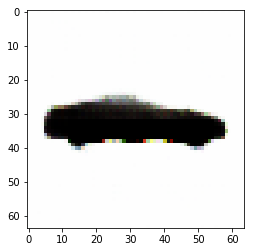

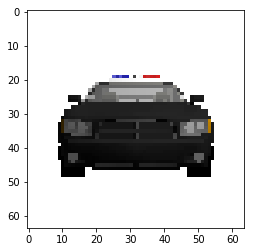

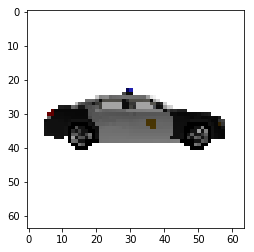

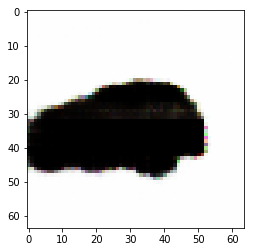

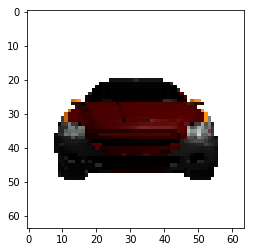

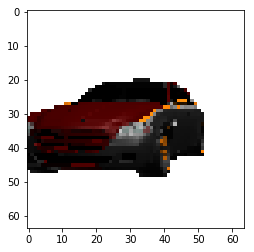

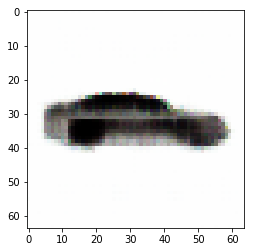

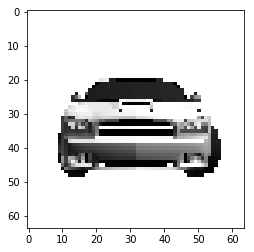

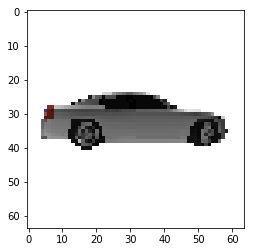

In [98]:
for j in range(batch_size):
    tmp = op[j]
    plt.imshow(tmp / 255)
    plt.show()

    plt.imshow(denormalize(test_batch[j])/255)
    plt.show()

    plt.imshow(denormalize(test_labels[j])/255)
    plt.show()